In [55]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp

from IPython.display import clear_output
import statistics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print(train.shape)
print(train.columns)
print(test.shape)
print(test.columns)

(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
(418, 11)
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### Adding features

In [4]:
'''人名/稱謂''' # ['Title_Capt', 'Title_Lady', 'Title_Major', 'Title_Sir', 'Title_the Countess']
train['Title'] = train.Name.str.split(', ').str[1].str.split('.').str[0].str.strip()
train['Title'] = train['Title'].replace({'Ms':'Miss', 'Mlle':'Miss', 'Mme':'Mrs', 
                                         'Rev':'Titled', 'Don':'Titled', 'Jonkheer':'Titled', 
                                         'Capt':'Titled', 'Lady':'Titled', 'Major':'Titled', 
                                         'Sir':'Titled', 'the Countess':'Titled'})
'''個人&家庭狀況'''
train['fam_size'] = train['SibSp'] + train['Parch'] + 1
train['Alone'] = (train['fam_size']==1)
train['Alone'] = train['Alone'].astype(int)
train['Married_F'] = (train['Title'] != 'Miss') & (train['Sex'] == 'female')
#df_train['Married_F'] = df_train['Married_F'].astype(int)
#df_train['fam_Class'] = df_train['fam_size'] * df_train['Pclass']

'''住宿'''
train['Deck'] = train['Cabin'].str.slice(0, 1)
train['Deck'] = pd.Categorical(train['Deck'], categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Z'])

'''經濟狀況'''
train['fare_perp'] = train['Fare']/train['fam_size']

One-way ANOVA preassumptions：
* Normality --> stats.shapiro
* Homoskedasticity --> stats.levene
* Independence --> depends on sampling method
*    reference：https://www.pythonfordatascience.org/anova-python/#anova_scipy_stats



            N     Mean       SD      SE  95% Conf.  Interval
Survived                                                    
0         424  30.6262  14.1721  0.6883    29.2733   31.9790
1         290  28.3437  14.9510  0.8780    26.6157   30.0717
                    sum_sq     df         F    PR(>F)
C(Survived)     897.187582    1.0  4.271195  0.039125
Residual     149559.448362  712.0       NaN       NaN
(0.9824720025062561, 1.533871625269967e-07)


LeveneResult(statistic=1.1953828843934424, pvalue=0.27461621560000243)

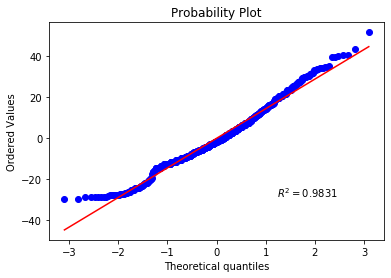

In [64]:
#stats.f_oneway(train[train['Survived'] == 1]['Age'], train[train['Survived'] == 0]['Age'])
print(rp.summary_cont(train['Age'].groupby(train['Survived'])))
model = ols('Age ~ C(Survived)', data=train).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)
print(stats.shapiro(model.resid)) # Did not pass normality test
normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
stats.levene(train['Age'][train['Survived'] == 1].dropna(),
             train['Age'][train['Survived'] == 0].dropna()) # have non-statistically significant varability



            N     Mean       SD      SE  95% Conf.  Interval
Survived                                                    
0         549  22.1179  31.3882  1.3396    19.4865   24.7493
1         342  48.3954  66.5970  3.6012    41.3121   55.4787
                   sum_sq     df          F        PR(>F)
C(Survived)  1.455089e+05    1.0  63.030764  6.120189e-15
Residual     2.052290e+06  889.0        NaN           NaN
(0.5871959924697876, 1.5461927255360032e-41)


LeveneResult(statistic=45.09964096576531, pvalue=3.337352710626e-11)

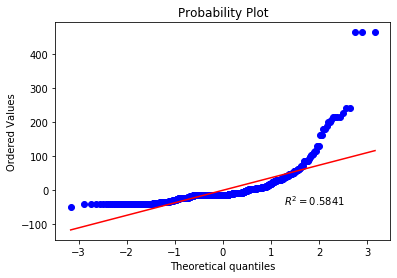

In [32]:
print(rp.summary_cont(train['Fare'].groupby(train['Survived'])))
model = ols('Fare ~ C(Survived)', data=train).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)
print(stats.shapiro(model.resid)) # Did not pass normality test (p-value significant)
normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
stats.levene(train['Fare'][train['Survived'] == 1].dropna(),
             train['Fare'][train['Survived'] == 0].dropna()) # heteroskedasticity



            N    Mean      SD      SE  95% Conf.  Interval
Survived                                                  
0         549  1.8834  1.8307  0.0781     1.7300    2.0369
1         342  1.9386  1.1861  0.0641     1.8124    2.0647
                  sum_sq     df         F    PR(>F)
C(Survived)     0.641445    1.0  0.246193  0.619891
Residual     2316.249688  889.0       NaN       NaN
(0.6214359998703003, 2.708906113324877e-40)


LeveneResult(statistic=0.006444356314184613, pvalue=0.9360352181633312)

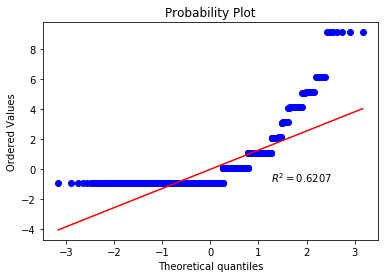

In [63]:
print(rp.summary_cont(train['fam_size'].groupby(train['Survived'])))
model = ols('fam_size ~ C(Survived)', data=train).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table) # insignificant
print(stats.shapiro(model.resid)) # Did not pass normality test (p-value significant)
normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
stats.levene(train['fam_size'][train['Survived'] == 1].dropna(),
             train['fam_size'][train['Survived'] == 0].dropna()) # homoskedasticity

### Chi-Square Test of Independence
* reference：https://predictivehacks.com/how-to-run-chi-square-test-in-python/

Chi-Square： 263.05057407065567 Degree of Freedom： 1 p-value： 3.711747770113424e-59
Reject Null Hypothesis --> Variables are dependent.
Chi-Square： 102.88898875696056 Degree of Freedom： 2 p-value： 4.549251711298793e-23
Reject Null Hypothesis --> Variables are dependent.
Chi-Square： 36.85013084754587 Degree of Freedom： 1 p-value： 1.2756752813177417e-09
Reject Null Hypothesis --> Variables are dependent.


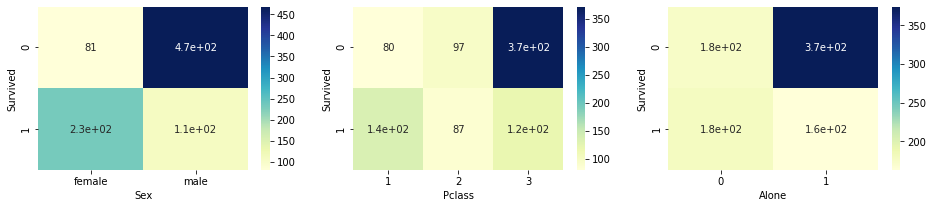

In [44]:
# Construct crosstable # , normalize='index' or 'column' or 'all'--> 百分比
# Null Hypothesis： Variables are independent`
def chi_test(y = train.Survived, x = train.Sex, mar=False):
    y_x = pd.crosstab(y, x, margins=mar)
    chi2, p, dof, ex = stats.chi2_contingency(y_x, correction=False)
    print("Chi-Square：",chi2, "Degree of Freedom：",dof, "p-value：", p)
    if p <= 0.05:
        print("Reject Null Hypothesis --> Variables are dependent.")
    else:
        print("Fail to reject --> Variables may be independent.")
    return y_x

y_sex = chi_test() # Sex & Survived are dependent
y_pclass = chi_test(x=train.Pclass) # Pclass & Survived are dependent
y_alone = chi_test(x=train.Alone) # Alone & Survived are dependent
fig, axs = plt.subplots(1, 3, figsize = (16, 3))

sns.heatmap(y_sex, annot=True, cmap="YlGnBu", ax = axs[0])
sns.heatmap(y_pclass, annot=True, cmap="YlGnBu", ax = axs[1])
sns.heatmap(y_alone, annot=True, cmap="YlGnBu", ax = axs[2])

Chi-Square： 10.300556313502582 Degree of Freedom： 7 p-value： 0.1721713412821439
Fail to reject --> Variables may be independent.


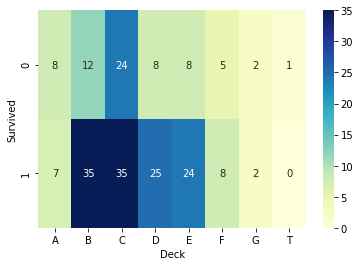

In [61]:
y_deck = chi_test(x=train.Deck) 
sns.heatmap(y_deck, annot=True, cmap="YlGnBu")

In [59]:
# If chi-square test is significant, we then use POST-HOC test to varify group difference
# FWER is the probability of making Type-I error --> use procecure to control FWER
# Bonferroni procedure, Šidák procedure, Tukey's procedure, Holm's step-down procedure, ...
# https://en.wikipedia.org/wiki/Family-wise_error_rate#Controlling_procedures
sp.posthoc_ttest(train, val_col='Survived', group_col='Alone', p_adjust='bonf')
# All three variables are proved to have statistically different groups

,0,1
0,1.000000e+00,9.009490e-10
1,9.009490e-10,1.000000e+00


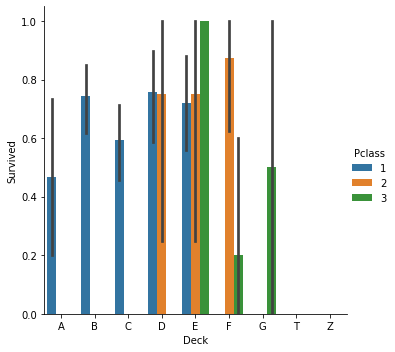

In [13]:
sns.catplot(data = train, x = 'Deck', y = 'Survived', hue = 'Pclass', kind = 'bar')

### Missing Data

In [48]:
#print(train.isnull().sum()) 
# Age、Cabin、Embarked needs Imputation
print(train['Cabin'].isnull().sum())
# --> change Cabin to Deck (categorical)
print(train['Age'].isnull().sum())
# --> fill by 'famsize' mean
print(train['Embarked'].isnull().sum())
# --> fill by mode

687
177
2


##### Embarked

In [49]:
train['Embarked'] = train['Embarked'].fillna(statistics.mode(train['Embarked'].dropna()))

##### Cabin --> Deck

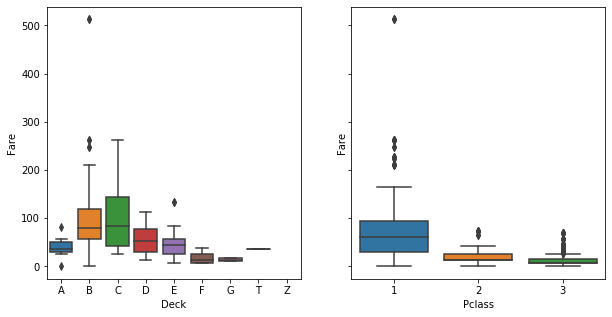

In [50]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), sharey = True)
sns.boxplot(train['Deck'], train['Fare'], ax = axs[0])
sns.boxplot(train['Pclass'], train['Fare'], ax = axs[1])
# No obvious correlation between 'Deck' and 'Pclass'
#sns.catplot(data = train, kind = "bar", x = "Deck", y = "Fare", 
 #           hue="Pclass", ci="sd", palette="dark", alpha=.6)

In [51]:
train['Deck'] = train['Deck'].fillna(statistics.mode(train['Deck'].dropna()))
train['Deck'].isnull().sum()

0

##### Age

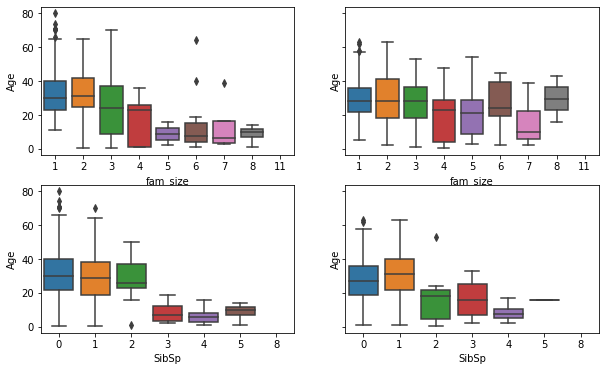

In [10]:
#sns.boxplot(train['Sex'], train['Age']) # similar mean
fig, axs = plt.subplots(2, 2, figsize = (10, 6), sharey = True)
male = train[train['Sex'] == 'male']
female = train[train['Sex'] == 'female']
sns.boxplot(male['SibSp'], male['Age'], ax = axs[1][0])
sns.boxplot(male['fam_size'], male['Age'], ax = axs[0][0])
sns.boxplot(female['SibSp'], female['Age'], ax = axs[1][1])
sns.boxplot(female['fam_size'], female['Age'], ax = axs[0][1])

In [52]:
# fill age.na by fam_size age
for ind, row in train.iterrows():
    if ind % 100 == 0:
        clear_output(True)
    if pd.isna(train.loc[ind, 'Age']):
        if train.loc[ind, 'fam_size'] <= 8:
            #print(ind)
            famsize = train.loc[ind, 'fam_size']
            same_group = train[train['fam_size'] == famsize]
            age_mean = np.mean(same_group['Age'])
            train.loc[ind, 'Age'] = age_mean
        else:
            same_group = train[train['fam_size'] == 8]
            age_mean = np.mean(same_group['Age'])
            train.loc[ind, 'Age'] = age_mean

print(train[train['Age'].isnull()])

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked, Title, fam_size, Alone, Married_F, Deck, fare_perp]
Index: []


### Encoding & Scaling

In [54]:
new_train = train.drop(['Ticket', 'Cabin', 'Name', 'PassengerId'], axis = 1)
print(new_train.shape)
numeric = new_train.select_dtypes(include=np.number).columns
category = new_train.select_dtypes(include=['object', 'category']).columns
print(category)
new_train = pd.get_dummies(new_train, columns = list(category), dummy_na = False, drop_first = False)
print(new_train.shape)
print([x for x in new_train.columns if x.startswith("Title")])
new_train = new_train.drop(['Sex_male'], axis = 1)
new_train = new_train.rename(columns = {'Sex_female':'Sex'})
new_train.head(3)

(891, 14)
Index(['Sex', 'Embarked', 'Title', 'Deck'], dtype='object')
(891, 31)
['Title_Col', 'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Titled']


,Survived,Pclass,Age,SibSp,Parch,Fare,fam_size,Alone,Married_F,fare_perp,...,Title_Titled,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Z
0,0,3,22.0,1,0,7.2500,2,0,False,3.62500,...,0,0,0,1,0,0,0,0,0,0
1,1,1,38.0,1,0,71.2833,2,0,True,35.64165,...,0,0,0,1,0,0,0,0,0,0
2,1,3,26.0,0,0,7.9250,1,1,False,7.92500,...,0,0,0,1,0,0,0,0,0,0


(array([537., 161., 102.,  29.,  15.,  22.,  12.,   6.,   0.,   7.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <a list of 10 Patch objects>)

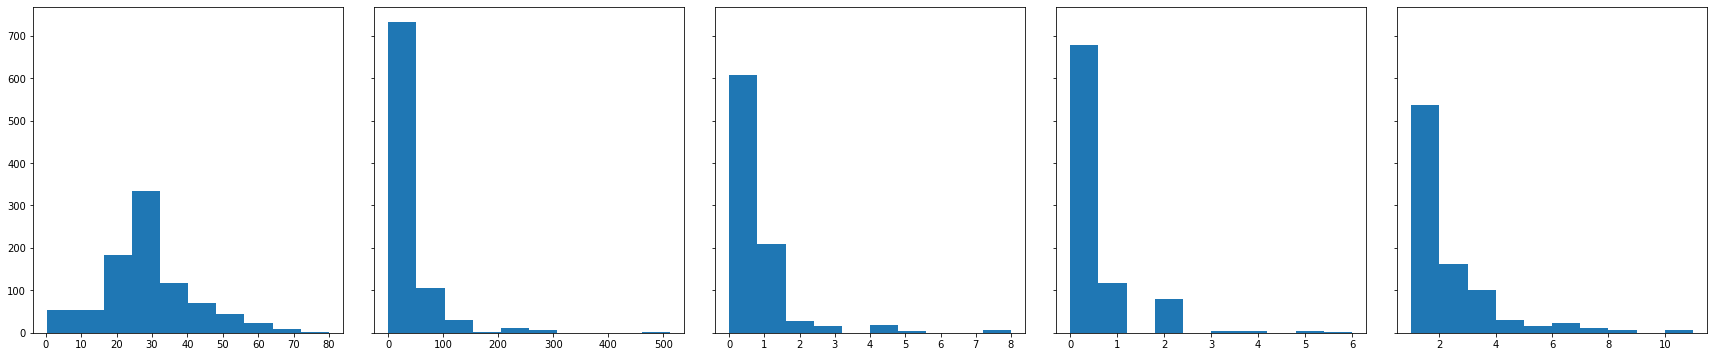

In [13]:
# Looking at (numeric)feature distributions --> 多為偏態
fig, axs = plt.subplots(1, 5, figsize = (30, 6), gridspec_kw = {'wspace':0.1}, sharey = True)
axs[0].hist(train['Age'])
axs[1].hist(train['Fare'])
axs[2].hist(train['SibSp'])
axs[3].hist(train['Parch'])
axs[4].hist(train['fam_size'])

In [55]:
# Use Standardized Scaling
stand_scaler = StandardScaler()
new_train_sd = stand_scaler.fit_transform(new_train)
new_train_sd = pd.DataFrame(new_train_sd, columns = new_train.columns)
print(new_train_sd.shape)
new_train_sd['Survived'] = train['Survived']
new_train_sd.head(3)

(891, 30)


,Survived,Pclass,Age,SibSp,Parch,Fare,fam_size,Alone,Married_F,fare_perp,...,Title_Titled,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Z
0,0,0.827377,-0.602414,0.432793,-0.473674,-0.502445,0.059160,-1.231645,-0.411450,-0.454798,...,-0.126347,-0.130856,-0.235981,0.440874,-0.196116,-0.193009,-0.121681,-0.067153,-0.03352,0.0
1,1,-1.566107,0.616973,0.432793,-0.473674,0.786845,0.059160,-1.231645,2.430427,0.438994,...,-0.126347,-0.130856,-0.235981,0.440874,-0.196116,-0.193009,-0.121681,-0.067153,-0.03352,0.0
2,1,0.827377,-0.297567,-0.474545,-0.473674,-0.488854,-0.560975,0.811922,-0.411450,-0.334757,...,-0.126347,-0.130856,-0.235981,0.440874,-0.196116,-0.193009,-0.121681,-0.067153,-0.03352,0.0


In [56]:
# Use Min-Max Scaling
minmax_scaler = MinMaxScaler()
new_train_minmax = minmax_scaler.fit_transform(new_train)
new_train_minmax = pd.DataFrame(new_train_minmax, columns = new_train.columns)
print(new_train_minmax.shape)
new_train_minmax.head(3)

(891, 30)


,Survived,Pclass,Age,SibSp,Parch,Fare,fam_size,Alone,Married_F,fare_perp,...,Title_Titled,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Z
0,0.0,1.0,0.271174,0.125,0.0,0.014151,0.1,0.0,0.0,0.007076,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.472229,0.125,0.0,0.139136,0.1,0.0,1.0,0.069568,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.321438,0.000,0.0,0.015469,0.0,1.0,0.0,0.015469,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
fig, axs = plt.subplots(1, 5, figsize = (30, 6), gridspec_kw = {'wspace':0.1}, sharey = True)
axs[0].hist(new_train_minmax['Age'])
axs[1].hist(new_train_minmax['Fare'])
axs[2].hist(new_train_minmax['SibSp'])
axs[3].hist(new_train_minmax['Parch'])
axs[4].hist(new_train_minmax['fam_size'])

### Feature Selection

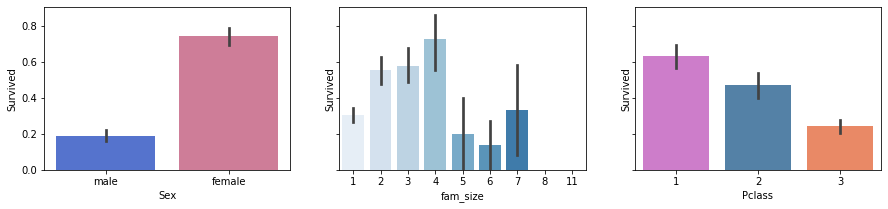

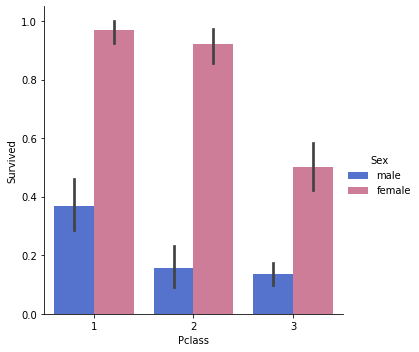

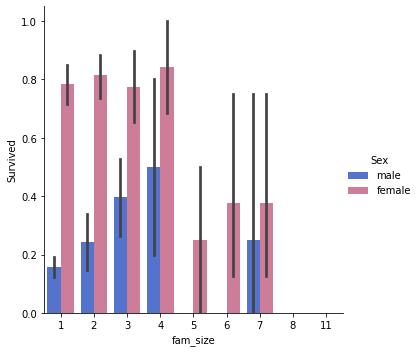

In [57]:
fig, axs = plt.subplots(1, 3, figsize = (15, 3), sharey = True)
sns.barplot(train['Sex'], train['Survived'], ax = axs[0], palette = ['royalblue', 'palevioletred'])
sns.barplot(train['fam_size'], train['Survived'], ax = axs[1], palette = "Blues")
sns.barplot(train['Pclass'], train['Survived'], ax = axs[2], palette = ['orchid', 'steelblue', 'coral'])
plt.show()
sns.catplot(data = train, x = 'Pclass', y = 'Survived', hue = 'Sex', kind = "bar", 
            palette = ['royalblue', 'palevioletred'])
sns.catplot(data = train, x = 'fam_size', y = 'Survived', hue = 'Sex', kind = "bar", 
            palette = ['royalblue', 'palevioletred'])

In [117]:
# check correlation of columns # use 1.correlation 2.PCA to get features
cor = new_train_sd.corr()
high_corr = dict(cor[abs(cor['Survived'].values) >= 0.1]['Survived'].sort_values(ascending=False)[1:])
sel_feats = list(high_corr.keys())
print(sel_feats)

['Sex', 'Married_F', 'Title_Mrs', 'Title_Miss', 'Fare', 'fare_perp', 'Deck_B', 'Embarked_C', 'Deck_D', 'Deck_E', 'Embarked_S', 'Alone', 'Deck_C', 'Pclass', 'Title_Mr']


C:\Users\racco\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until


In [118]:
x_train, x_test, y_train, y_test = train_test_split(new_train[sel_feats], 
                                                    new_train_sd['Survived'], 
                                                    test_size = 0.3, random_state = 17)
# new_train_sd.drop('Survived', axis = 1)
print("Shape of train x:", x_train.shape)
print("Shape of test x:", x_test.shape)
print("Shape of train y:", y_train.shape)
print("Shape of test y:", y_test.shape)

Shape of train x: (623, 15)
Shape of test x: (268, 15)
Shape of train y: (623,)
Shape of test y: (268,)


In [ ]:
#y_pred

In [121]:
xgb = XGBClassifier(n_estimators=5, eval_metric = 'error', #'error',
                    learning_rate = 0.7, reg_lambda = 0.4, max_depth = 3).fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.7947761194029851
Precision:  0.8181818181818182
Confusion Matrix:
 [[141  16]
 [ 39  72]]
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       157
           1       0.82      0.65      0.72       111

    accuracy                           0.79       268
   macro avg       0.80      0.77      0.78       268
weighted avg       0.80      0.79      0.79       268



In [122]:
# elasticnet False Positive較多, accuracy不高但precision高
clf = LogisticRegression(solver='saga', penalty='elasticnet', C=0.8, l1_ratio=0.5,
                         random_state=0, class_weight="balanced", max_iter=600).fit(x_train, y_train)
# penalty: 'l1', 'l2', 'elasticnet'; solver:'liblinear', 'saga'
y_pred = clf.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.7388059701492538
Precision:  0.759493670886076
Confusion Matrix:
 [[138  19]
 [ 51  60]]
              precision    recall  f1-score   support

           0       0.73      0.88      0.80       157
           1       0.76      0.54      0.63       111

    accuracy                           0.74       268
   macro avg       0.74      0.71      0.71       268
weighted avg       0.74      0.74      0.73       268



C:\Users\racco\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [124]:
svclassifier = SVC(C=0.5, kernel='linear', class_weight=None)#"balanced") #'sigmoid', 'poly', 'rbf', 'linear'
svclassifier.fit(x_train, y_train)
y_pred = svclassifier.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy:  0.753731343283582
Precision:  0.7184466019417476
Confusion Matrix:
 [[128  29]
 [ 37  74]]
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       157
           1       0.72      0.67      0.69       111

    accuracy                           0.75       268
   macro avg       0.75      0.74      0.74       268
weighted avg       0.75      0.75      0.75       268



In [23]:
test.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [83]:
# test.isnull().sum() # Age, Fare, Cabin --> fillna
'''人名/稱謂'''
test['Title'] = test.Name.str.split(', ').str[1].str.split('.').str[0].str.strip()
test['Title'] = test['Title'].replace({'Ms':'Miss', 'Mlle':'Miss', 'Mme':'Mrs', 
                                         'Rev':'Titled', 'Don':'Titled', 'Dona':'Titled', 
                                         'Jonkheer':'Titled'})
'''個人&家庭狀況'''
test['fam_size'] = test['SibSp'] + test['Parch'] + 1
test['Alone'] = (test['fam_size']==1)
test['Alone'] = test['Alone'].astype(int)
test['Married_F'] = (test['Title'] != 'Miss') & (test['Sex'] == 'female')
#df_train['Married_F'] = df_train['Married_F'].astype(int)
#df_train['fam_Class'] = df_train['fam_size'] * df_train['Pclass']

'''住宿'''
test['Deck'] = test['Cabin'].str.slice(0, 1)
test['Deck'] = pd.Categorical(test['Deck'], categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Z'])
test['Deck'] = test['Deck'].fillna(statistics.mode(test['Deck'].dropna()))
print("Deck:", test['Deck'].isnull().sum())

'''經濟狀況'''
test['Fare'] = test['Fare'].fillna(np.mean(test[test['Pclass']==3]['Fare']))
test['fare_perp'] = test['Fare']/test['fam_size']
for ind, row in test.iterrows():
    if ind % 100 == 0:
        clear_output(True)
    if pd.isna(test.loc[ind, 'Age']):
        if test.loc[ind, 'fam_size'] <= 8:
            #print(ind)
            famsize = test.loc[ind, 'fam_size']
            same_group = test[test['fam_size'] == famsize]
            age_mean = np.mean(same_group['Age'])
            test.loc[ind, 'Age'] = age_mean
        else:
            same_group = test[test['fam_size'] == 8]
            age_mean = np.mean(same_group['Age'])
            test.loc[ind, 'Age'] = age_mean
print("Age:", test[test['Age'].isnull()])

Age: Empty DataFrame
Columns: [PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked, Title, fam_size, Alone, Married_F, Deck, fare_perp]
Index: []


In [84]:
new_test = test.drop(['Ticket', 'Cabin', 'Name', 'PassengerId'], axis = 1)
print(new_test.shape)
numeric = new_test.select_dtypes(include=np.number).columns
category = new_test.select_dtypes(include=['object', 'category']).columns
print(category)
new_test = pd.get_dummies(new_test, columns = list(category), dummy_na = False, drop_first = False)
print(new_test.shape)
print([x for x in new_test.columns if x.startswith("Title")])
new_test = new_test.drop(['Sex_male'], axis = 1)
new_test = new_test.rename(columns = {'Sex_female':'Sex'})
new_test.head(3)

(418, 13)
Index(['Sex', 'Embarked', 'Title', 'Deck'], dtype='object')
(418, 30)
['Title_Col', 'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Titled']


,Pclass,Age,SibSp,Parch,Fare,fam_size,Alone,Married_F,fare_perp,Sex,...,Title_Titled,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Z
0,3,34.5,0,0,7.8292,1,1,False,7.8292,0,...,0,0,0,1,0,0,0,0,0,0
1,3,47.0,1,0,7.0000,2,0,True,3.5000,1,...,0,0,0,1,0,0,0,0,0,0
2,2,62.0,0,0,9.6875,1,1,False,9.6875,0,...,0,0,0,1,0,0,0,0,0,0


In [85]:
# Use Standardized Scaling
new_test_sd = stand_scaler.fit_transform(new_test)
new_test_sd = pd.DataFrame(new_test_sd, columns = new_test.columns)
print(new_test_sd.shape)
new_test_sd.head(3)

# Use Min-Max Scaling
new_test_minmax = minmax_scaler.fit_transform(new_test)
new_test_minmax = pd.DataFrame(new_test_minmax, columns = new_test.columns)
print(new_test_minmax.shape)
new_test_minmax.head(3)

(418, 29)
(418, 29)


,Pclass,Age,SibSp,Parch,Fare,fam_size,Alone,Married_F,fare_perp,Sex,...,Title_Titled,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Z
0,1.0,0.452723,0.000,0.0,0.015282,0.0,1.0,0.0,0.029840,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.617566,0.125,0.0,0.013663,0.1,0.0,1.0,0.013340,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.5,0.815377,0.000,0.0,0.018909,0.0,1.0,0.0,0.036922,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
#print(new_train.columns, new_train.shape[1]) 
#print(new_test.columns) 
#missing_cols = ['Title_Capt', 'Title_Lady', 'Title_Major', 'Title_Sir', 'Title_the Countess']
#for i in range(len(missing_cols)):
 #   new_test[missing_cols[i]] = 0
new_test = new_test[sel_feats]
#new_test = new_test[x_train.columns]
print(new_test.shape)
new_test.head(3)

(418, 19)


,Sex,Married_F,Title_Mrs,Title_Miss,Fare,fare_perp,Deck_B,Embarked_C,Deck_D,Deck_E,Title_Master,Parch,Deck_F,Age,Embarked_S,Alone,Deck_C,Pclass,Title_Mr
0,0,False,0,0,7.8292,7.8292,0,0,0,0,0,0,0,34.5,0,1,1,3,1
1,1,True,1,0,7.0000,3.5000,0,0,0,0,0,0,0,47.0,1,0,1,3,0
2,0,False,0,0,9.6875,9.6875,0,0,0,0,0,0,0,62.0,0,1,1,2,1


In [95]:
test_pred = clf.predict(new_test)#xgb.predict(new_test)
test_pred

ValueError: X has 19 features per sample; expecting 29

In [89]:
submission = pd.DataFrame(columns = ['PassengerId', 'Survived'])
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = test_pred
submission.head(3)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0


In [94]:
submission.to_csv('submission.csv', index = False)